In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')

from utilities import data
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## directory where results are
EXPERIMENT_DIR = f"W:/experiments/lung-malignancy-fairness-shaurya"
CHANSEY_NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
LOCAL_NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)
NLST_PREDS = LOCAL_NLST_PREDS

In [21]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 128 entries, PatientID to NoduleType
dtypes: bool(27), float64(86), int64(11), object(4)
memory usage: 12.8+ MB


In [22]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

nlst_democols['num'].pop('nodule')

['CoordX', 'CoordZ', 'CoordY']

In [23]:

nlst_democols

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter [mm]']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   'cancoral',
   'cancpanc',
   'canccerv',
   'cancstom',
   'canct

In [24]:
nlst_preds = data.prep_nlst_preds(nlst_preds_nodule, scanlevel=True, tijmen=False, sybil=True)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5911 entries, 0 to 10182
Columns: 122 entries, PatientID to NoduleType
dtypes: bool(27), float64(82), int64(11), object(2)
memory usage: 4.5+ MB


In [8]:
nlst_policy_thresholds = pd.read_csv(f"{NLST_PREDS}/policy-thresholds-{len(nlst_preds)}.csv", index_col=0)
nlst_policy_thresholds

,Sensitivity=0.9,Specificity=0.9,Youden J=1.0,Brock,col
Venkadesh,0.048,0.219,0.112,0.06,DL_cal
de Haas Local,0.045,0.212,0.144,0.06,Thijmen_local_cal
de Haas Global (w/nodule),0.068,0.300,0.131,0.06,Thijmen_global_show_cal
Sybil year 1,0.003,0.057,0.017,0.06,sybil_year1
PanCan2b,0.015,0.165,0.035,0.06,PanCan2b


In [9]:
THRESHOLD = 'Brock'

In [48]:
sybil_worse_df = pd.read_csv(f"{NLST_PREDS}/sybil_worse.csv")
sybil_worse_df

,col,sym,val
0,wrknomask,=,True
1,FamilyHistoryLungCa,=,True
2,Emphysema,=,True
3,Gender,=,1
4,Married,=,True
5,wrkasbe,=,1
6,wrkfoun,=,1
7,diagadas,=,1
8,diagcopd,=,1
9,diagpneu,=,1


Sybil's worse columns are from our [scan level AUC results](./plot_nlst_scanlevel.ipynb).

PanCan columns from [Radiopaedia](https://radiopaedia.org/articles/brock-model-for-pulmonary-nodules).

The gender differential columns are from the "What about men vs women?" section of the [training info demographic splits notebook](./nlst/nlst_traininfo.ipynb).

In [11]:
pancan_cols = ['Age', 'Gender', 'race', 'FamilyHistoryLungCa', 'Emphysema', 'Diameter [mm]', 'NoduleInUpperLung', 'PartSolid', 'NoduleCounts', 'Spiculation']
train_diff_cols = ['pipe', 'cigar', 'Married', 'wrknomask', 'wrkfarm', 'smokework', 'diaghear', 'diagasbe', 'smokelive', 'diagpneu', 'diagchro', 'diagcopd', 'PersonalCancerHist', 'cigsmok', 'cancbrea', 'pkyr', 'smokeage']
relevant_cols = list(set(list(sybil_worse_df['col']) + pancan_cols + train_diff_cols + nlst_democols['cat']['lungcanc'] + nlst_democols['cat']['nodule']))

In [12]:
relevant_cols

['wrknomask',
 'wrkasbe',
 'Age',
 'Diameter [mm]',
 'diagadas',
 'cancbrea',
 'Squamous_cell_carcinoma',
 'LC_stage',
 'Perifissural',
 'wrkfoun',
 'diagasbe',
 'PersonalCancerHist',
 'pipe',
 'BMI',
 'smokeage',
 'FamilyHistoryLungCa',
 'smokework',
 'NoduleCounts',
 'race',
 'diaghear',
 'weight',
 'smokelive',
 'Adenosquamous_carcinoma',
 'PartSolid',
 'cigsmok',
 'Small_cell_carcinoma',
 'Calcified',
 'height',
 'NonSolid',
 'GroundGlassOpacity',
 'pkyr',
 'Spiculation',
 'diagpneu',
 'diagchro',
 'Gender',
 'Adenocarcinoma',
 'Bronchiolo-alveolar_carcinoma',
 'Solid',
 'wrkfarm',
 'Carcinoid_tumor',
 'diagcopd',
 'SemiSolid',
 'cigar',
 'Unclassified_carcinoma',
 'Large_cell_carcinoma',
 'NoduleInUpperLung',
 'Emphysema',
 'Married']

In [13]:
nlst_preds[['sybil_year1']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5911 entries, 0 to 10182
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sybil_year1  5911 non-null   float64
dtypes: float64(1)
memory usage: 92.4 KB


In [14]:
MODEL_TO_COL = {
    "Venkadesh": "DL_cal",
    # "de Haas Combined": "Thijmen_mean_cal",
    "de Haas Local": "Thijmen_local_cal",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (w/nodule)": "Thijmen_global_show_cal",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [15]:
nlst_preds['Sybil_pred_label'] = (nlst_preds[MODEL_TO_COL['Sybil']] > nlst_policy_thresholds.loc['Sybil year 1', THRESHOLD]).astype(int).to_numpy()
nlst_preds['Sybil_PanCan_diff'] = nlst_preds[MODEL_TO_COL['Sybil']] - nlst_preds['PanCan2b']

In [16]:
false_positives = nlst_preds.query("label == 0 and Sybil_pred_label == 1")
false_negatives = nlst_preds.query("label == 1 and Sybil_pred_label == 0")

true_positives = nlst_preds.query("label == 1 and Sybil_pred_label == 1")
true_negatives = nlst_preds.query("label == 0 and Sybil_pred_label == 0")

## Difference between TP/FP/TN/FN

In [17]:
result_sets = {
    "FP": false_positives,
    "FN": false_negatives,
    "TP": true_positives,
    "TN": true_negatives, 
}

### utility code

In [18]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, dfsets=result_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

In [19]:
def cat_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
        dfdict[f"{m}_freq"].fillna(0, inplace=True)
        dfdict[f"{m}_norm"].fillna(0, inplace=True)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)
    
    df = pd.DataFrame(dfdict).drop_duplicates()

    for m in dfsets:
        df[f"{m}_freq"] = df[f"{m}_freq"].fillna(0.0)
        df[f"{m}_norm"] = df[f"{m}_norm"].fillna(0.0)

    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                df[f"diff_norm_{m1}_{m2}"] = (df[f"{m1}_norm"] - df[f"{m2}_norm"]).round(4)    

    # df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [20]:
def num_dist_df(c='Gender', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    # display(df)
    df.drop(index=['count', 'max', 'min', 'std'], inplace=True)
    return df

### differences

In [21]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_sets).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_TP', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))
cat_demo_splits.sort_values(by='diff_norm_FP_TP', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\569958293.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(cat_demo_splits.sort_values(by='diff_norm_FP_TP', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
220,lungcanc,LC_stage,NaN,511.0,100.0000,7.0,2.8807,8.0,2.3669,4819.0,100.0000,97.1193,97.6331,0.0000,0.5138,-97.1193,-97.6331
204,nodule,SemiSolid,1.0,168.0,32.8767,0.0,0.0000,0.0,0.0000,584.0,12.1187,32.8767,32.8767,20.7580,0.0000,-12.1187,-12.1187
188,nodule,GroundGlassOpacity,1.0,100.0,19.5695,0.0,0.0000,0.0,0.0000,1536.0,31.8738,19.5695,19.5695,-12.3043,0.0000,-31.8738,-31.8738
72,work,wrkfarm,1.0,79.0,15.4599,22.0,9.0535,25.0,7.3964,587.0,12.1810,6.4064,8.0635,3.2789,1.6571,-3.1275,-4.7846
190,nodule,NoduleInUpperLung,1.0,360.0,70.4501,136.0,55.9671,212.0,62.7219,2353.0,48.8276,14.4830,7.7282,21.6225,-6.7548,7.1395,13.8943
192,nodule,Perifissural,1.0,37.0,7.2407,0.0,0.0000,0.0,0.0000,487.0,10.1058,7.2407,7.2407,-2.8651,0.0000,-10.1058,-10.1058
126,disease,diagadas,1.0,58.0,11.3503,22.0,9.0535,17.0,5.0296,278.0,5.7688,2.2968,6.3207,5.5815,4.0239,3.2847,-0.7392
102,disease,diagpneu,1.0,144.0,28.1800,62.0,25.5144,74.0,21.8935,1102.0,22.8678,2.6656,6.2865,5.3122,3.6209,2.6466,-0.9743
210,other,wrknomask,1.0,138.0,27.0059,68.0,27.9835,71.0,21.0059,1227.0,25.4617,-0.9776,6.0000,1.5442,6.9776,2.5218,-4.4558
141,disease,diagchro,1.0,75.0,14.6771,26.0,10.6996,30.0,8.8757,488.0,10.1266,3.9775,5.8014,4.5505,1.8239,0.5730,-1.2509


C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\569958293.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_demo_splits.sort_values(by='diff_norm_FP_TP', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
213,lungcanc,LC_stage,110.0,0.0,0.0000,130.0,53.4979,165.0,48.8166,0.0,0.0000,-53.4979,-48.8166,0.0000,4.6813,53.4979,48.8166
230,lungcanc,Adenocarcinoma,1.0,0.0,0.0000,84.0,34.5679,149.0,44.0828,0.0,0.0000,-34.5679,-44.0828,0.0000,-9.5149,34.5679,44.0828
200,nodule,PartSolid,1.0,0.0,0.0000,25.0,10.2881,78.0,23.0769,0.0,0.0000,-10.2881,-23.0769,0.0000,-12.7888,10.2881,23.0769
226,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0000,37.0,15.2263,61.0,18.0473,0.0,0.0000,-15.2263,-18.0473,0.0000,-2.8210,15.2263,18.0473
232,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0000,60.0,24.6914,60.0,17.7515,0.0,0.0000,-24.6914,-17.7515,0.0000,6.9399,24.6914,17.7515
214,lungcanc,LC_stage,120.0,0.0,0.0000,13.0,5.3498,48.0,14.2012,0.0,0.0000,-5.3498,-14.2012,0.0000,-8.8514,5.3498,14.2012
217,lungcanc,LC_stage,310.0,0.0,0.0000,21.0,8.6420,39.0,11.5385,0.0,0.0000,-8.6420,-11.5385,0.0000,-2.8965,8.6420,11.5385
234,lungcanc,Unclassified_carcinoma,1.0,0.0,0.0000,32.0,13.1687,39.0,11.5385,0.0,0.0000,-13.1687,-11.5385,0.0000,1.6302,13.1687,11.5385
219,lungcanc,LC_stage,400.0,0.0,0.0000,38.0,15.6379,36.0,10.6509,0.0,0.0000,-15.6379,-10.6509,0.0000,4.9870,15.6379,10.6509
46,smoke,cigsmok,1.0,238.0,46.5753,128.0,52.6749,186.0,55.0296,2429.0,50.4046,-6.0996,-8.4543,-3.8293,-2.3547,2.2703,4.6250


In [22]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_sets).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).query('category == "nodule"'))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).query('category == "nodule"')

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
204,nodule,SemiSolid,1.0,168.0,32.8767,0.0,0.0000,0.0,0.0000,584.0,12.1187,32.8767,32.8767,20.7580,0.0000,-12.1187,-12.1187
188,nodule,GroundGlassOpacity,1.0,100.0,19.5695,0.0,0.0000,0.0,0.0000,1536.0,31.8738,19.5695,19.5695,-12.3043,0.0000,-31.8738,-31.8738
190,nodule,NoduleInUpperLung,1.0,360.0,70.4501,136.0,55.9671,212.0,62.7219,2353.0,48.8276,14.4830,7.7282,21.6225,-6.7548,7.1395,13.8943
192,nodule,Perifissural,1.0,37.0,7.2407,0.0,0.0000,0.0,0.0000,487.0,10.1058,7.2407,7.2407,-2.8651,0.0000,-10.1058,-10.1058
196,nodule,Calcified,1.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,5.0,0.1038,0.0000,0.0000,-0.1038,0.0000,-0.1038,-0.1038
198,nodule,Spiculation,1.0,0.0,0.0000,0.0,0.0000,10.0,2.9586,1.0,0.0208,0.0000,-2.9586,-0.0208,-2.9586,-0.0208,2.9378
202,nodule,Solid,1.0,357.0,69.8630,185.0,76.1317,252.0,74.5562,3206.0,66.5283,-6.2687,-4.6932,3.3347,1.5755,9.6034,8.0279
200,nodule,PartSolid,1.0,0.0,0.0000,25.0,10.2881,78.0,23.0769,0.0,0.0000,-10.2881,-23.0769,0.0000,-12.7888,10.2881,23.0769
194,nodule,NonSolid,1.0,0.0,0.0000,39.0,16.0494,14.0,4.1420,0.0,0.0000,-16.0494,-4.1420,0.0000,11.9074,16.0494,4.1420


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
194,nodule,NonSolid,1.0,0.0,0.0000,39.0,16.0494,14.0,4.1420,0.0,0.0000,-16.0494,-4.1420,0.0000,11.9074,16.0494,4.1420
200,nodule,PartSolid,1.0,0.0,0.0000,25.0,10.2881,78.0,23.0769,0.0,0.0000,-10.2881,-23.0769,0.0000,-12.7888,10.2881,23.0769
202,nodule,Solid,1.0,357.0,69.8630,185.0,76.1317,252.0,74.5562,3206.0,66.5283,-6.2687,-4.6932,3.3347,1.5755,9.6034,8.0279
196,nodule,Calcified,1.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,5.0,0.1038,0.0000,0.0000,-0.1038,0.0000,-0.1038,-0.1038
198,nodule,Spiculation,1.0,0.0,0.0000,0.0,0.0000,10.0,2.9586,1.0,0.0208,0.0000,-2.9586,-0.0208,-2.9586,-0.0208,2.9378
192,nodule,Perifissural,1.0,37.0,7.2407,0.0,0.0000,0.0,0.0000,487.0,10.1058,7.2407,7.2407,-2.8651,0.0000,-10.1058,-10.1058
190,nodule,NoduleInUpperLung,1.0,360.0,70.4501,136.0,55.9671,212.0,62.7219,2353.0,48.8276,14.4830,7.7282,21.6225,-6.7548,7.1395,13.8943
188,nodule,GroundGlassOpacity,1.0,100.0,19.5695,0.0,0.0000,0.0,0.0000,1536.0,31.8738,19.5695,19.5695,-12.3043,0.0000,-31.8738,-31.8738
204,nodule,SemiSolid,1.0,168.0,32.8767,0.0,0.0000,0.0,0.0000,584.0,12.1187,32.8767,32.8767,20.7580,0.0000,-12.1187,-12.1187


In [23]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_sets)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\2685756118.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
18,other,Diameter [mm],50%,12.5000,8.9000,14.6500,6.5000,3.6000,-2.1500,6.0000,-5.7500,2.4000,8.1500
19,other,Diameter [mm],mean,14.0337,11.3691,16.8672,7.8539,2.6646,-2.8335,6.1798,-5.4981,3.5152,9.0133
2,demo,Age,50%,64.0000,63.0000,64.0000,62.0000,1.0000,0.0000,2.0000,-1.0000,1.0000,2.0000
3,demo,Age,mean,64.1389,63.6008,64.3935,62.9768,0.5381,-0.2546,1.1621,-0.7927,0.6240,1.4167
9,smoke,smokeage,mean,16.4364,15.9877,16.3609,16.5333,0.4487,0.0755,-0.0969,-0.3732,-0.5456,-0.1724
17,other,NoduleCounts,mean,2.0020,1.9835,2.5059,1.8425,0.0185,-0.5039,0.1595,-0.5224,0.1410,0.6634
1,demo,BMI,mean,26.8548,26.8472,26.7522,27.7205,0.0076,0.1026,-0.8657,0.0950,-0.8733,-0.9683
16,other,NoduleCounts,50%,2.0000,2.0000,2.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,demo,BMI,50%,26.3839,26.4488,25.9964,27.1219,-0.0649,0.3875,-0.7380,0.4524,-0.6731,-1.1255


C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\2685756118.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
6,demo,weight,50%,172.0000,180.0000,170.0000,180.0000,-8.0000,2.0000,-8.0000,10.0000,0.0000,-10.0000
15,smoke,pkyr,mean,59.3614,63.5418,68.0504,57.2580,-4.1804,-8.6890,2.1034,-4.5086,6.2838,10.7924
14,smoke,pkyr,50%,51.2500,55.0000,57.0000,50.0000,-3.7500,-5.7500,1.2500,-2.0000,5.0000,7.0000
7,demo,weight,mean,176.9214,178.9050,174.7207,183.1018,-1.9836,2.2007,-6.1804,4.1843,-4.1968,-8.3811
4,demo,height,50%,68.0000,69.0000,68.0000,68.0000,-1.0000,0.0000,0.0000,1.0000,1.0000,0.0000
5,demo,height,mean,67.8549,68.2355,67.6024,68.0067,-0.3806,0.2525,-0.1518,0.6331,0.2288,-0.4043
0,demo,BMI,50%,26.3839,26.4488,25.9964,27.1219,-0.0649,0.3875,-0.7380,0.4524,-0.6731,-1.1255
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,2.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
1,demo,BMI,mean,26.8548,26.8472,26.7522,27.7205,0.0076,0.1026,-0.8657,0.0950,-0.8733,-0.9683


### Now with the top 100 scores that were different from PanCan

In [24]:
result_top_100_diff = {
    "FP": false_positives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[0:100],
    "FN": false_negatives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[0:100],
}

In [25]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_top_100_diff).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\3354373395.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
165,lungcanc,LC_stage,NaN,100.0,100.0,2.0,2.0,98.0
150,nodule,SemiSolid,1.0,21.0,21.0,0.0,0.0,21.0
136,nodule,GroundGlassOpacity,1.0,20.0,20.0,0.0,0.0,20.0
138,nodule,NoduleInUpperLung,1.0,62.0,62.0,45.0,45.0,17.0
140,nodule,Perifissural,1.0,10.0,10.0,0.0,0.0,10.0
102,disease,diagadas,1.0,17.0,17.0,9.0,9.0,8.0
114,disease,diagchro,1.0,14.0,14.0,6.0,6.0,8.0
62,work,wrkfarm,1.0,17.0,17.0,11.0,11.0,6.0
156,other,wrknomask,1.0,29.0,29.0,24.0,24.0,5.0
104,disease,diagcopd,1.0,9.0,9.0,5.0,5.0,4.0


C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\3354373395.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
159,lungcanc,LC_stage,110.0,0.0,0.0,61.0,61.0,-61.0
175,lungcanc,Adenocarcinoma,1.0,0.0,0.0,46.0,46.0,-46.0
177,lungcanc,Squamous_cell_carcinoma,1.0,0.0,0.0,23.0,23.0,-23.0
179,lungcanc,Unclassified_carcinoma,1.0,0.0,0.0,13.0,13.0,-13.0
47,smoke,pipe,1.0,15.0,15.0,28.0,28.0,-13.0
142,nodule,NonSolid,1.0,0.0,0.0,12.0,12.0,-12.0
164,lungcanc,LC_stage,400.0,0.0,0.0,11.0,11.0,-11.0
161,lungcanc,LC_stage,210.0,0.0,0.0,8.0,8.0,-8.0
171,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,0.0,0.0,8.0,8.0,-8.0
13,demo,Married,1.0,63.0,63.0,71.0,71.0,-8.0


In [26]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, result_top_100_diff).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False).query("category == 'nodule'"))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True).query("category == 'nodule'")

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
150,nodule,SemiSolid,1.0,21.0,21.0,0.0,0.0,21.0
136,nodule,GroundGlassOpacity,1.0,20.0,20.0,0.0,0.0,20.0
138,nodule,NoduleInUpperLung,1.0,62.0,62.0,45.0,45.0,17.0
140,nodule,Perifissural,1.0,10.0,10.0,0.0,0.0,10.0
146,nodule,PartSolid,1.0,0.0,0.0,5.0,5.0,-5.0
148,nodule,Solid,1.0,78.0,78.0,85.0,85.0,-7.0
142,nodule,NonSolid,1.0,0.0,0.0,12.0,12.0,-12.0


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
142,nodule,NonSolid,1.0,0.0,0.0,12.0,12.0,-12.0
148,nodule,Solid,1.0,78.0,78.0,85.0,85.0,-7.0
146,nodule,PartSolid,1.0,0.0,0.0,5.0,5.0,-5.0
140,nodule,Perifissural,1.0,10.0,10.0,0.0,0.0,10.0
138,nodule,NoduleInUpperLung,1.0,62.0,62.0,45.0,45.0,17.0
136,nodule,GroundGlassOpacity,1.0,20.0,20.0,0.0,0.0,20.0
150,nodule,SemiSolid,1.0,21.0,21.0,0.0,0.0,21.0


In [27]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, result_top_100_diff)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\900221855.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,FP,FN,diff_FP_FN
7,demo,weight,mean,181.1600,174.3400,6.8200
14,smoke,pkyr,50%,63.8750,57.1250,6.7500
19,other,Diameter [mm],mean,11.0110,6.4690,4.5420
18,other,Diameter [mm],50%,10.4000,6.1500,4.2500
1,demo,BMI,mean,26.9934,26.2540,0.7394
9,smoke,smokeage,mean,16.3400,15.7800,0.5600
5,demo,height,mean,68.5100,68.0700,0.4400
4,demo,height,50%,68.0000,68.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,0.0000


C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\900221855.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,FP,FN,diff_FP_FN
2,demo,Age,50%,63.0000,64.0000,-1.0000
15,smoke,pkyr,mean,64.9935,65.6220,-0.6285
3,demo,Age,mean,63.2800,63.7900,-0.5100
6,demo,weight,50%,178.5000,179.0000,-0.5000
0,demo,BMI,50%,25.9846,26.4439,-0.4593
17,other,NoduleCounts,mean,2.0800,2.2000,-0.1200
8,smoke,smokeage,50%,16.0000,16.0000,0.0000
4,demo,height,50%,68.0000,68.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
5,demo,height,mean,68.5100,68.0700,0.4400


## True Positives

In [ ]:
true_positives = nlst_preds.query("label == 1 and Sybil_pred_label == 1")
true_positives['abs_Sybil_PanCan_diff'] = true_positives['Sybil_PanCan_diff'].apply(abs)
tp_top20 = true_positives.sort_values(by=['sybil_year1','abs_Sybil_PanCan_diff',  'PanCan2b'], ascending=[False, True, False]).head(20)
tp_top20[
    ['PatientID', 'label', 'Sybil_pred_label', 'PanCan2b', 'sybil_year1', 'abs_Sybil_PanCan_diff'] + nlst_democols['cat']['nodule'] + ['Emphysema', 'Gender', 'race', 'BMI', 'Age']
]

In [ ]:
tp_top20_series = tp_top20['SeriesInstanceUID'].tolist()

In [ ]:
tp_top20_save = nlst_preds_nodule[nlst_preds_nodule['SeriesInstanceUID'].isin(tp_top20_series)]

In [32]:
# tp_top20_save.to_csv(f"{CHANSEY_NLST_PREDS}/sybil_tp_brock_top20.csv", index=False)
tp_top20_save.to_csv(f"{LOCAL_NLST_PREDS}/sybil_tp_brock_top20.csv", index=False)

## False Positives

In [ ]:
false_positives = nlst_preds.query("label == 0 and Sybil_pred_label == 1")

<Axes: xlabel='Sybil_PanCan_diff', ylabel='Density'>

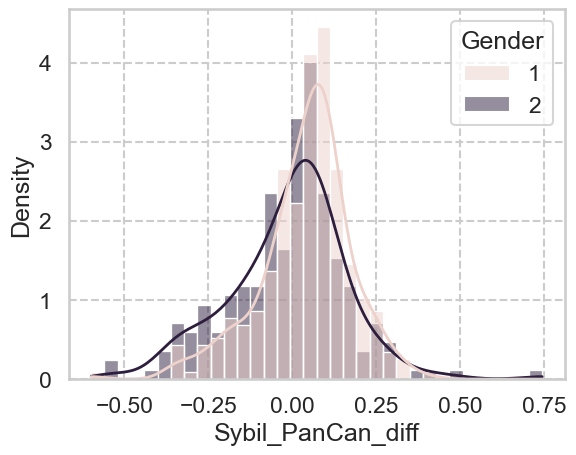

In [34]:
sns.histplot(false_positives, x='Sybil_PanCan_diff', hue='Gender', common_norm=False, element='bars', kde=True, stat='density')

### Select FPs for Attention Visualization

In [ ]:
fp_relevant_cols = [
    'sybil_year1', 'PanCan2b',
    'Gender', 'Age',  'race', 'BMI', 'Emphysema', 'NoduleInUpperLung', 
    'wrkasbe', 'wrkchem',  'wrkweld',
    'diagadas', 'diagcopd', 'diaghear', 'diagpneu',
    # 'diaghype', 'pkyr', 'cigar', 'pipe'
]
fp_top50 = false_positives.query('PanCan2b < 0.06').sort_values(by='Sybil_PanCan_diff', ascending=False).head(50)
display(fp_top50[fp_relevant_cols])

For further analysis. Not for getting attentions. For the above dataframe ONLY!!!!

In [36]:
# interesting_idxs = [2263, 3985, 929, 655, 2659, 2439, 1863, 726, 2459, 2676, 4627, 1832]

In [ ]:
# interesting_series = [fp_top50.loc[i, 'SeriesInstanceUID'] for i in interesting_idxs]

Get top 50 series IDs.

In [ ]:
fp_top50_series = fp_top50['SeriesInstanceUID'].tolist()

In [ ]:
fp_top50_save = nlst_preds_nodule[nlst_preds_nodule['SeriesInstanceUID'].isin(fp_top50_series)]

In [41]:
# fp_top50_save.to_csv(f"{CHANSEY_NLST_PREDS}/sybil_fp_brock_top50.csv", index=False)
fp_top50_save.to_csv(f"{LOCAL_NLST_PREDS}/sybil_fp_brock_top50.csv", index=False)

### Gender differences

In [42]:
gender_fps = {
    "M": false_positives.query("Gender == 1"),
    "F": false_positives.query("Gender == 2"),
}

In [43]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, gender_fps).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\43954872.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
10,demo,Gender,1,296.0,100.0000,0.0,0.0000,100.0000
42,smoke,cigar,1.0,93.0,31.4189,4.0,1.8605,29.5584
50,smoke,pipe,1.0,93.0,31.4189,6.0,2.7907,28.6282
167,other,wrknomask,True,111.0,37.5000,27.0,12.5581,24.9419
13,demo,Married,True,228.0,77.0270,119.0,55.3488,21.6782
65,work,wrkfarm,1.0,64.0,21.6216,15.0,6.9767,14.6449
102,disease,diaghear,1.0,66.0,22.2973,24.0,11.1628,11.1345
59,work,wrkasbe,1.0,29.0,9.7973,3.0,1.3953,8.4020
153,nodule,Perifissural,True,30.0,10.1351,7.0,3.2558,6.8793
45,smoke,cigsmok,1,146.0,49.3243,92.0,42.7907,6.5336


C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\43954872.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)[cat_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
11,demo,Gender,2,0.0,0.0000,215.0,100.0000,-100.0000
121,disease,diagchro,1.0,25.0,8.4459,50.0,23.2558,-14.8099
108,disease,diagadas,1.0,17.0,5.7432,41.0,19.0698,-13.3266
161,nodule,SemiSolid,True,85.0,28.7162,83.0,38.6047,-9.8885
87,disease,diagpneu,1.0,73.0,24.6622,71.0,33.0233,-8.3611
149,nodule,GroundGlassOpacity,True,49.0,16.5541,51.0,23.7209,-7.1668
110,disease,diagcopd,1.0,23.0,7.7703,32.0,14.8837,-7.1134
39,smoke,smokelive,1.0,255.0,86.1486,200.0,93.0233,-6.8747
165,other,PersonalCancerHist,True,5.0,1.6892,17.0,7.9070,-6.2178
163,other,FamilyHistoryLungCa,True,70.0,23.6486,60.0,27.9070,-4.2584


In [44]:
# num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, gender_fps)
# display(num_demo_splits.sort_values(by='diff_M_F', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
# num_demo_splits.sort_values(by='diff_M_F', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

## False Negatives

In [45]:
len(false_negatives)

243

In [ ]:
false_negatives.sort_values(by=['Sybil_PanCan_diff'], ascending=True)[[
     'PanCan2b', 'sybil_year1', 'Sybil_PanCan_diff', 
     'Age', 'Gender', 'race', 'weight', 'BMI',
     'Emphysema', 'Adenocarcinoma', 'pkyr', 'pipe', 'cigar', 
     'wrknomask', 'wrkfoun', 'wrkasbe', 'diaghype', 'diaghear'
    #  'Squamous_cell_carcinoma', 'Large_cell_carcinoma', 'diagcopd', 'NoduleInUpperLung', 'Solid'
]].head(25)

In [ ]:
fn_top_25_sybil = false_negatives.sort_values(by=['Sybil_PanCan_diff'], ascending=True).head(25)

In [48]:
fn_top_25_sybil.to_csv(f"{NLST_PREDS}/sybil_fn_brock_top25.csv")

### Gender differences

<Axes: xlabel='Sybil_PanCan_diff', ylabel='Density'>

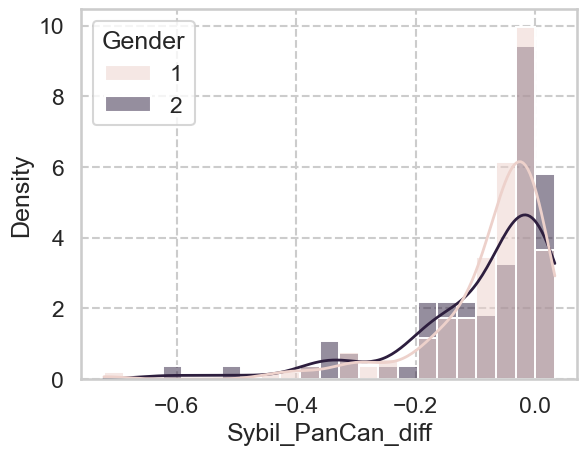

In [49]:
sns.histplot(false_negatives, x='Sybil_PanCan_diff', hue='Gender', common_norm=False, element='bars', kde=True, stat='density')

In [50]:
gender_fns = {
    "M": false_negatives.query("Gender == 1"),
    "F": false_negatives.query("Gender == 2"),
}

In [51]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, gender_fns).query('value != 0')
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False).head(30))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True).head(30)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
10,demo,Gender,1.0,159.0,100.0000,0.0,0.0000,100.0000
48,smoke,pipe,1.0,71.0,44.6541,0.0,0.0000,44.6541
40,smoke,cigar,1.0,56.0,35.2201,1.0,1.1905,34.0296
1,demo,Overweight,1.0,113.0,71.0692,44.0,52.3810,18.6882
190,other,wrknomask,1.0,52.0,32.7044,16.0,19.0476,13.6568
24,demo,marital,2.0,120.0,75.4717,52.0,61.9048,13.5669
13,demo,Married,1.0,120.0,75.4717,52.0,61.9048,13.5669
54,work,wrkfoun,1.0,20.0,12.5786,0.0,0.0000,12.5786
60,work,wrkasbe,1.0,21.0,13.2075,1.0,1.1905,12.0170
115,disease,diaghear,1.0,26.0,16.3522,5.0,5.9524,10.3998


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
11,demo,Gender,2.0,0.0,0.0000,84.0,100.0000,-100.0000
43,smoke,cigsmok,1.0,73.0,45.9119,55.0,65.4762,-19.5643
25,demo,marital,3.0,2.0,1.2579,17.0,20.2381,-18.9802
4,demo,educat,3.0,31.0,19.4969,29.0,34.5238,-15.0269
98,disease,diagpneu,1.0,33.0,20.7547,29.0,34.5238,-13.7691
186,other,FamilyHistoryLungCa,1.0,45.0,28.3019,32.0,38.0952,-9.7933
193,lungcanc,LC_stage,110.0,80.0,50.3145,50.0,59.5238,-9.2093
121,disease,diagadas,1.0,10.0,6.2893,12.0,14.2857,-7.9964
6,demo,educat,5.0,31.0,19.4969,23.0,27.3810,-7.8841
210,lungcanc,Adenocarcinoma,1.0,51.0,32.0755,33.0,39.2857,-7.2102


In [52]:
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False).query('category == "nodule"'))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True).query('category == "nodule"')

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
174,nodule,NoduleInUpperLung,1.0,93.0,58.4906,43.0,51.1905,7.3001
183,nodule,Solid,1.0,123.0,77.3585,62.0,73.8095,3.5490
181,nodule,PartSolid,1.0,15.0,9.4340,10.0,11.9048,-2.4708
177,nodule,NonSolid,1.0,24.0,15.0943,15.0,17.8571,-2.7628


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
177,nodule,NonSolid,1.0,24.0,15.0943,15.0,17.8571,-2.7628
181,nodule,PartSolid,1.0,15.0,9.4340,10.0,11.9048,-2.4708
183,nodule,Solid,1.0,123.0,77.3585,62.0,73.8095,3.5490
174,nodule,NoduleInUpperLung,1.0,93.0,58.4906,43.0,51.1905,7.3001


In [53]:
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False).query('attribute == "LC_stage"'))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True).query('attribute == "LC_stage"')

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
199,lungcanc,LC_stage,400.0,30.0,18.8679,8.0,9.5238,9.3441
198,lungcanc,LC_stage,320.0,11.0,6.9182,3.0,3.5714,3.3468
195,lungcanc,LC_stage,210.0,11.0,6.9182,4.0,4.7619,2.1563
194,lungcanc,LC_stage,120.0,9.0,5.6604,4.0,4.7619,0.8985
197,lungcanc,LC_stage,310.0,14.0,8.8050,7.0,8.3333,0.4717
200,lungcanc,LC_stage,NaN,4.0,2.5157,3.0,3.5714,-1.0557
196,lungcanc,LC_stage,220.0,0.0,0.0000,5.0,5.9524,-5.9524
193,lungcanc,LC_stage,110.0,80.0,50.3145,50.0,59.5238,-9.2093


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
193,lungcanc,LC_stage,110.0,80.0,50.3145,50.0,59.5238,-9.2093
196,lungcanc,LC_stage,220.0,0.0,0.0000,5.0,5.9524,-5.9524
200,lungcanc,LC_stage,NaN,4.0,2.5157,3.0,3.5714,-1.0557
197,lungcanc,LC_stage,310.0,14.0,8.8050,7.0,8.3333,0.4717
194,lungcanc,LC_stage,120.0,9.0,5.6604,4.0,4.7619,0.8985
195,lungcanc,LC_stage,210.0,11.0,6.9182,4.0,4.7619,2.1563
198,lungcanc,LC_stage,320.0,11.0,6.9182,3.0,3.5714,3.3468
199,lungcanc,LC_stage,400.0,30.0,18.8679,8.0,9.5238,9.3441


In [54]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, gender_fns)
display(num_demo_splits.sort_values(by='diff_M_F', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))
num_demo_splits.sort_values(by='diff_M_F', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\3369854996.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_demo_splits.sort_values(by='diff_M_F', ascending=False)[num_demo_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,M,F,diff_M_F
7,demo,weight,mean,193.0506,152.2976,40.7530
6,demo,weight,50%,185.0000,150.0000,35.0000
15,smoke,pkyr,mean,68.2632,54.6048,13.6584
14,smoke,pkyr,50%,61.5000,49.5000,12.0000
4,demo,height,50%,71.0000,64.0000,7.0000
5,demo,height,mean,70.3987,64.1667,6.2320
19,other,Diameter [mm],mean,12.2182,9.7619,2.4563
2,demo,Age,50%,64.0000,62.5000,1.5000
1,demo,BMI,mean,27.3643,25.8747,1.4896
18,other,Diameter [mm],50%,9.7000,8.3000,1.4000


C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\3369854996.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_demo_splits.sort_values(by='diff_M_F', ascending=True)[num_demo_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,M,F,diff_M_F
9,smoke,smokeage,mean,15.5723,16.7738,-1.2015
17,other,NoduleCounts,mean,1.8679,2.2024,-0.3345
8,smoke,smokeage,50%,16.0000,16.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
3,demo,Age,mean,63.7296,63.3571,0.3725
0,demo,BMI,50%,26.5784,25.3377,1.2407
18,other,Diameter [mm],50%,9.7000,8.3000,1.4000
1,demo,BMI,mean,27.3643,25.8747,1.4896
2,demo,Age,50%,64.0000,62.5000,1.5000
19,other,Diameter [mm],mean,12.2182,9.7619,2.4563


### Racial differences

<Axes: xlabel='Sybil_PanCan_diff', ylabel='Count'>

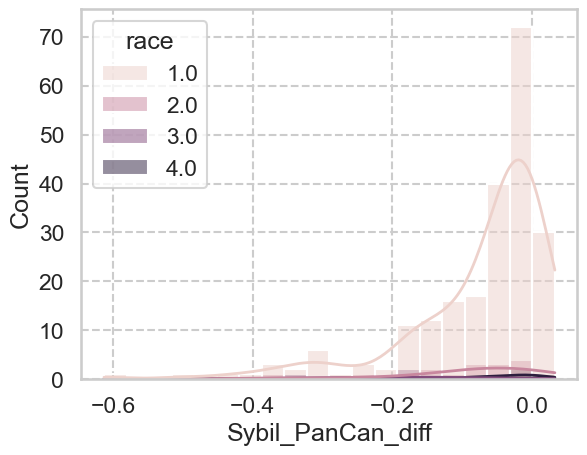

In [55]:
sns.histplot(false_negatives, x='Sybil_PanCan_diff', hue='race', common_norm=False, element='bars', kde=True)

In [56]:
false_negatives['race'].value_counts()

race
1.0    219
2.0     16
3.0      4
4.0      3
Name: count, dtype: int64

In [57]:
race_fns = {
    "white": false_negatives.query("race == 1"),
    "black": false_negatives.query("race == 2"),    
}

In [58]:
cat_race_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_fns).query('value != 0')
display(cat_race_splits.sort_values(by='diff_norm_white_black', ascending=False).head(30))
cat_race_splits.sort_values(by='diff_norm_white_black', ascending=True).head(30)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
30,demo,race,1.0,219.0,100.0000,0.0,0.00,100.0000
20,demo,WhiteOrBlack,1.0,219.0,100.0000,0.0,0.00,100.0000
17,demo,NonHispanicWhite,1.0,218.0,99.5434,0.0,0.00,99.5434
15,demo,HighSchoolPlus,1.0,217.0,99.0868,13.0,81.25,17.8368
40,smoke,smokework,1.0,188.0,85.8447,11.0,68.75,17.0947
13,demo,Married,1.0,157.0,71.6895,9.0,56.25,15.4395
23,demo,marital,2.0,157.0,71.6895,9.0,56.25,15.4395
36,smoke,cigar,1.0,55.0,25.1142,2.0,12.50,12.6142
8,demo,educat,7.0,26.0,11.8721,0.0,0.00,11.8721
81,disease,diagemph,1.0,26.0,11.8721,0.0,0.00,11.8721


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
31,demo,race,2.0,0.0,0.0000,16.0,100.00,-100.0000
21,demo,WhiteOrBlack,2.0,0.0,0.0000,16.0,100.00,-100.0000
159,other,wrknomask,1.0,55.0,25.1142,8.0,50.00,-24.8858
47,work,wrkfoun,1.0,15.0,6.8493,5.0,31.25,-24.4007
104,disease,diaghype,1.0,85.0,38.8128,10.0,62.50,-23.6872
3,demo,educat,2.0,8.0,3.6530,4.0,25.00,-21.3470
183,lungcanc,Unclassified_carcinoma,1.0,25.0,11.4155,5.0,31.25,-19.8345
70,work,wrkcott,1.0,1.0,0.4566,3.0,18.75,-18.2934
2,demo,educat,1.0,2.0,0.9132,3.0,18.75,-17.8368
38,smoke,cigsmok,1.0,113.0,51.5982,11.0,68.75,-17.1518


In [59]:
display(cat_race_splits.sort_values(by='diff_norm_white_black', ascending=False).query('category == "nodule"'))
cat_race_splits.sort_values(by='diff_norm_white_black', ascending=True).query('category == "nodule"')

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
143,nodule,NoduleInUpperLung,1.0,125.0,57.0776,8.0,50.00,7.0776
146,nodule,NonSolid,1.0,37.0,16.8950,2.0,12.50,4.3950
150,nodule,PartSolid,1.0,23.0,10.5023,1.0,6.25,4.2523
152,nodule,Solid,1.0,164.0,74.8858,13.0,81.25,-6.3642


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
152,nodule,Solid,1.0,164.0,74.8858,13.0,81.25,-6.3642
150,nodule,PartSolid,1.0,23.0,10.5023,1.0,6.25,4.2523
146,nodule,NonSolid,1.0,37.0,16.8950,2.0,12.50,4.3950
143,nodule,NoduleInUpperLung,1.0,125.0,57.0776,8.0,50.00,7.0776


In [60]:
display(cat_race_splits.sort_values(by='diff_norm_white_black', ascending=False).query('attribute == "LC_stage"'))
cat_race_splits.sort_values(by='diff_norm_white_black', ascending=True).query('attribute == "LC_stage"')

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
162,lungcanc,LC_stage,110.0,121.0,55.2511,7.0,43.75,11.5011
163,lungcanc,LC_stage,120.0,13.0,5.9361,0.0,0.00,5.9361
169,lungcanc,LC_stage,NaN,7.0,3.1963,0.0,0.00,3.1963
166,lungcanc,LC_stage,310.0,16.0,7.3059,1.0,6.25,1.0559
164,lungcanc,LC_stage,210.0,12.0,5.4795,1.0,6.25,-0.7705
165,lungcanc,LC_stage,220.0,4.0,1.8265,1.0,6.25,-4.4235
167,lungcanc,LC_stage,320.0,12.0,5.4795,2.0,12.50,-7.0205
168,lungcanc,LC_stage,400.0,34.0,15.5251,4.0,25.00,-9.4749


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
168,lungcanc,LC_stage,400.0,34.0,15.5251,4.0,25.00,-9.4749
167,lungcanc,LC_stage,320.0,12.0,5.4795,2.0,12.50,-7.0205
165,lungcanc,LC_stage,220.0,4.0,1.8265,1.0,6.25,-4.4235
164,lungcanc,LC_stage,210.0,12.0,5.4795,1.0,6.25,-0.7705
166,lungcanc,LC_stage,310.0,16.0,7.3059,1.0,6.25,1.0559
169,lungcanc,LC_stage,NaN,7.0,3.1963,0.0,0.00,3.1963
163,lungcanc,LC_stage,120.0,13.0,5.9361,0.0,0.00,5.9361
162,lungcanc,LC_stage,110.0,121.0,55.2511,7.0,43.75,11.5011


In [61]:
num_race_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, race_fns)
display(num_race_splits.sort_values(by='diff_white_black', ascending=False)[num_race_splits['attribute'].isin(relevant_cols)].head(20))
num_race_splits.sort_values(by='diff_white_black', ascending=True)[num_race_splits['attribute'].isin(relevant_cols)].head(20)

C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\3321663929.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(num_race_splits.sort_values(by='diff_white_black', ascending=False)[num_race_splits['attribute'].isin(relevant_cols)].head(20))


,category,attribute,value,white,black,diff_white_black
15,smoke,pkyr,mean,64.3329,45.3594,18.9735
14,smoke,pkyr,50%,56.2500,39.0000,17.2500
6,demo,weight,50%,180.0000,178.0000,2.0000
0,demo,BMI,50%,26.4537,25.0647,1.3890
3,demo,Age,mean,63.5616,63.0625,0.4991
5,demo,height,mean,68.3562,68.1875,0.1687
17,other,NoduleCounts,mean,2.0137,1.9375,0.0762
2,demo,Age,50%,63.0000,63.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
1,demo,BMI,mean,26.9538,27.4366,-0.4828


C:\Users\shaur\AppData\Local\Temp\ipykernel_21524\3321663929.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_race_splits.sort_values(by='diff_white_black', ascending=True)[num_race_splits['attribute'].isin(relevant_cols)].head(20)


,category,attribute,value,white,black,diff_white_black
19,other,Diameter [mm],mean,10.9731,13.2938,-2.3207
4,demo,height,50%,69.0000,71.0000,-2.0000
8,smoke,smokeage,50%,16.0000,18.0000,-2.0000
9,smoke,smokeage,mean,15.9863,17.3125,-1.3262
7,demo,weight,mean,180.1507,180.8750,-0.7243
18,other,Diameter [mm],50%,8.8000,9.4000,-0.6000
1,demo,BMI,mean,26.9538,27.4366,-0.4828
2,demo,Age,50%,63.0000,63.0000,0.0000
16,other,NoduleCounts,50%,2.0000,2.0000,0.0000
17,other,NoduleCounts,mean,2.0137,1.9375,0.0762


In [62]:
fn_black_series = false_negatives.query('race == 2')['SeriesInstanceUID'].tolist()
len(fn_black_series)

16

In [ ]:
fn_black_sybil = nlst_preds_nodule[nlst_preds_nodule['SeriesInstanceUID'].isin(fn_black_series)]

In [65]:
fn_black_sybil.to_csv(f"{NLST_PREDS}/sybil_fn_brock_black.csv")
# fn_black_sybil.to_csv(f"{CHANSEY_NLST_PREDS}/sybil_fn_brock_black.csv")

## What do our radiologist's notes line up with?

### False Negatives

In [ ]:
fn_traits = pd.read_csv(f"{NLST_PREDS}/Sybil-Heatmap-Info/ernst-sybil-fn-traits.csv")

In [ ]:
fn_traits2 = fn_traits.merge(false_negatives, how='left', on='SeriesInstanceUID', copy=False, suffixes=('', ''))

### False Positives

In [ ]:
fp_top50 = pd.read_csv(f"{NLST_PREDS}/Sybil-Heatmap-Info/sybil_fp_brock_top50.csv")

In [ ]:
fp_traits = pd.read_csv(f"{NLST_PREDS}/Sybil-Heatmap-Info/ernst-sybil-fp-tp-traits.csv").query('PredType == "FP"')

In [72]:
fp_traits['AttnOnAreaNotes'].fillna('', inplace=True)
fp_traits['OtherNotes'].fillna('', inplace=True)

In [ ]:
fp_traits2 = fp_traits.merge(nlst_preds, how='left', on='SeriesInstanceUID', copy=False, suffixes=('', ''))
fp_traits2[['Reader', 'AttnOnTumor', 'Zshift', 'AbnormalAttn','AttnOnAreaNotes', 'OtherNotes'] + ['PanCan2b', 'sybil_year1', 'BMI', 'Gender', 'race', 'Emphysema', 'diaghype']]

In [77]:
fp_traits['AttnOnAreaNotes'].str.contains('normal').sum()

np.int64(19)

In [ ]:
fp_traits2.query('AbnormalAttn == True')[['AttnOnTumor', 'AttnOnAreaNotes', 'Gender', 'race', 'BMI', "NoduleCounts", 'wrknomask', 'wrkfarm', 'diaghear', 'diaghype', 'diagcopd', 'diagadas', 'diagpneu', 'cigar', 'pipe'] + list(sybil_worse_df['col']) + nlst_democols['cat']['other'] + nlst_democols['cat']['disease'] + nlst_democols['cat']['work']]

In [79]:
fp_abnormal = fp_traits2.query('AbnormalAttn == True and Reader == "SG"')
len(fp_abnormal)

16

In [ ]:
gender_key = {1: 'Male', 2: 'Female'}
race_key = {1.0: 'White American', 2.0: 'Black American', 3.0: 'Asian American'}

def weight_cat(bmi):
    if bmi < 18.5: return 'underweight'
    if bmi < 25: return 'normal weight'
    if bmi < 30: return 'overweight'
    return 'obese'

def list_workhist(row):
    workhist_key = {
        'wrkasbe': 'Asbestos',
        'wrkbaki': 'Baking',
        'wrkbutc': 'Butcher',
        'wrkchem': 'Chemicals / plastics manufacturing',
        'wrkfarm': 'Farmwork',
        'wrkfire': 'Firefighting',
        'wrkfoun': 'Foundry',
        'wrkpain': 'Painting',
        'wrksand': 'Sandblasting',
        'wrkweld': 'Welding'
    }
    out_strs = []
    for col in nlst_democols['cat']['work']:
        if col in workhist_key and row[col]:
            out_strs.append(workhist_key[col])
    
    return ", ".join(out_strs)

# for i, (index, row) in enumerate(fp_abnormal.iterrows()):
#     if row['Reader'] == 'ES': continue
#     print(f"Scan {i+1}/{len(fp_abnormal)}")
#     print("Series Instance UID:", row['SeriesInstanceUID'], "\n")
#     print(f"Scan with heatmaps: \t serie_{row['SeriesInstanceUID']}.mha")
#     print(f"Scan with NO heatmaps: \t noattn_{row['SeriesInstanceUID']}.mha")

#     if row['AttnOnAreaNotes'] or row['OtherNotes']: print(f"\nNotes from Shaurya:")
#     if row['AttnOnAreaNotes']: print(f"  - Attention: {row['AttnOnAreaNotes']}")
#     if row['OtherNotes']: print(f"  - Other: {row['OtherNotes']}")
    
#     print(f"\nGender: {gender_key[row['Gender']]} \t Race: {race_key[row['race']]} \t Body Mass Index: {row['BMI']:.2f} ({weight_cat(row['BMI'])})")
    
#     print(f"\nEmphysema in scan: {'YES' if row['Emphysema'] else 'NO'} \t Previous diagnosis of hypertension: {'YES' if row['diaghype'] else 'NO'}")
    
#     print(f"\nFamily History of Lung Cancer: {'YES' if row['FamilyHistoryLungCa'] else 'NO'}")

#     print(f"\nDid patient smoke a cigar? {'YES' if row['cigar'] else 'NO'} \t Did patient smoke a pipe? {'YES' if row['pipe'] else 'NO'}")
    
#     print(f"\nDid patient work in a field high-risk for the lungs (according to NLST) without a mask? {'YES' if row['wrknomask'] else 'NO'}")

#     workhist_str = list_workhist(row)
#     if workhist_str != "": print(f"\nWork history (1 or more years) in: {list_workhist(row)}")

#     print("\n\n")

## Do our false positives and false negatives exist in Sybil's set?

In [16]:
sybil_fp     = pd.read_csv(f"{NLST_PREDS}/Sybil-Heatmap-Info/ernst-sybil-fp-tp-traits.csv").query('PredType == "FP"')
sybil_tp     = pd.read_csv(f"{NLST_PREDS}/Sybil-Heatmap-Info/ernst-sybil-fp-tp-traits.csv").query('PredType == "TP"')
sybil_fn     = pd.read_csv(f"{NLST_PREDS}/Sybil-Heatmap-Info/ernst-sybil-fn-traits.csv")
sybil_splits = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-splitinfo.csv")

In [13]:
sybil_train_series = set(sybil_splits['SeriesInstanceUID'].tolist())